In [ ]:
#Import thư viện
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
import seaborn as sns
import shutil

from glob import glob
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import itertools

import PIL
import cv2
from google.colab.patches import cv2_imshow
import pickle

#Huấn luyện mô hình với HOG và SVM

In [ ]:
# Đọc ảnh
neg_paths = glob('/content/drive/MyDrive/Human Motivation Detection/image-neg2/*')
pos_paths = glob('/content/drive/MyDrive/Human Motivation Detection/image-pos2/*')
print('Số lượng ảnh người đi bộ: ' + str(len(pos_paths)))
print('Số lượng ảnh nhãn âm (ảnh các phương tiện giao thông): ' + str(len(neg_paths)))

Số lượng ảnh người đi bộ: 4738
Số lượng ảnh nhãn âm (ảnh các phương tiện giao thông): 5315


In [ ]:
# Đưa ảnh về ma trận numpy
np_pos_img = []
np_neg_img = []
start_time = time.time()
for path in pos_paths:
  temp_img = np.asarray(PIL.Image.open(path))
  np_pos_img.append(temp_img)
for path in neg_paths:
  temp_img = np.asarray(PIL.Image.open(path))
  np_neg_img.append(temp_img)
print("reading images in %s seconds" % (time.time() - start_time))

reading images in 17.04863929748535 seconds


Đọc ảnh và trích rút đặc trưng

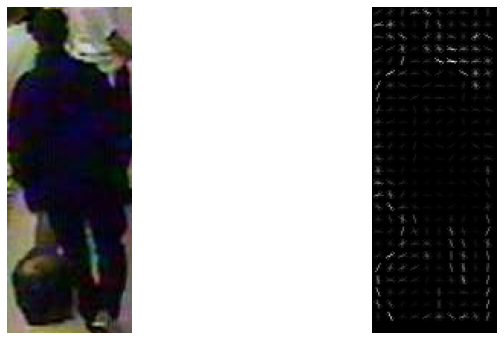

In [ ]:
# Ví dụ
example_image = np_pos_img[2000]
hog_features,visualized = hog(example_image,
                              visualize=True,
                              multichannel=True
                             )

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
#Hàm trích chọn đặc trưng với đầu vào là numpy_img, đầu ra là vector đặc trưng HOG
def feature_extraction_image(img):
  rs = cv2.cvtColor(cv2.resize(img,(64,128)),cv2.COLOR_RGB2GRAY)
  rs = hog(rs, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys')
  return rs


In [ ]:
# Trích chọn đặc trưng các ảnh
pos_images = []
pos_labels = np.ones(len(np_pos_img))
for img in np_pos_img:  
  img = feature_extraction_image(img)
  pos_images.append(img)

neg_images = []
neg_labels = np.zeros(len(np_neg_img))
for img in np_neg_img:  
  img = feature_extraction_image(img)
  neg_images.append(img)

In [ ]:
#Tạo tập dữ liệu huấn luyện
x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

print("Shape of image set",x.shape)
print("Shape of labels",y.shape)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

Shape of image set (10053, 6804)
Shape of labels (10053,)


In [ ]:
#Function to plot confusion matrix
#------------------------------------------------------------------------------------------------------------------------------
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
del x, y, neg_images, neg_labels, pos_images, pos_labels, np_pos_img, np_neg_img, pos_paths, neg_paths

In [ ]:
#Huấn luyện mô hình
start_time = time.time()
linearSVC = LinearSVC()
linearSVC.fit(x_train,y_train)
print("finish training in %s seconds" % (time.time() - start_time))
y_pred = linearSVC.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

finish training in 20.74661636352539 seconds
Accuracy: 0.9696668324216807


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1042
         1.0       0.97      0.97      0.97       969

    accuracy                           0.97      2011
   macro avg       0.97      0.97      0.97      2011
weighted avg       0.97      0.97      0.97      2011



Confusion matrix, without normalization
[[1009   33]
 [  28  941]]


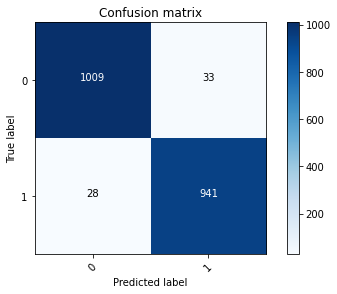

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

In [ ]:
#Lưu model
pickle.dump(linearSVC, open('/content/drive/MyDrive/Human Motivation Detection/linearSVM_model.h5', 'wb'))